# Extension of Basic gimVI tutorial: Reproduce GimVI results
## Impute missing genes in Spatial Data from Sequencing Data

In [1]:
import sys

# sys.path.append("../../")
# sys.path.append("../scVI/")
# sys.path.append("../scVI/tests/")

import warnings
warnings.filterwarnings('ignore')

In [2]:
save_path = "data"

In [3]:
from scvi.dataset import (
    GeneExpressionDataset,
    PreFrontalCortexStarmapDataset,
    FrontalCortexDropseqDataset,
    SmfishDataset,
    CortexDataset,
)
from scvi.models import JVAE, Classifier, VAE
from scvi.inference import JVAETrainer, UnsupervisedTrainer
import numpy as np
import copy
import matplotlib.pyplot as plt

In [4]:
from benchmarkable import Data, SeuratV3, Liger, Coral, Benchmarkable
from benchmarkable import scVI as ScVI
from plot_benchmarkable import PlotBenchmarkable

R[write to console]: During startup - 
R[write to console]: Warning messages:

R[write to console]: 1: Setting LC_COLLATE failed, using "C" 

R[write to console]: 2: Setting LC_TIME failed, using "C" 

R[write to console]: 3: Setting LC_MESSAGES failed, using "C" 

R[write to console]: 4: Setting LC_MONETARY failed, using "C" 



## Load two datasets: one with spatial data, one from sequencing

Here we load: 
- **Cortex**: a scRNA-seq dataset of 3,005 mouse somatosensory cortex cells (Zeisel et al., 2015)
- **osmFISH**: a smFISH dataset of 4,462 cells and 33 genes from the same tissue (Codeluppi et al., 2018)

In [5]:
data_spatial = SmfishDataset(save_path=save_path)
data_seq = CortexDataset(
    save_path=save_path, genes_to_keep=data_spatial.gene_names, total_genes=None
)

[2020-01-05 22:36:13,043] INFO - scvi.dataset.dataset | File /Users/anazaret/Documents/data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
[2020-01-05 22:36:13,044] INFO - scvi.dataset.smfish | Loading smFISH dataset
[2020-01-05 22:36:13,081] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2020-01-05 22:36:13,085] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:13,086] INFO - scvi.dataset.dataset | Downsampled from 6471 to 4530 cells
[2020-01-05 22:36:13,087] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 22:36:13,088] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-05 22:36:13,090] INFO - scvi.dataset.dataset | File /Users/anazaret/Documents/data/expression.bin already downloaded
[2020-01-05 22:36:13,090] INFO - scvi.dataset.cortex | Loading Cortex data
[2020-01-05 22:36:22

**Hide some genes in the spatial dataset to score the imputation**

In [6]:
data_seq.filter_cells_by_count(1)
data_spatial.filter_cells_by_count(1)

[2020-01-05 22:36:22,615] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:22,616] INFO - scvi.dataset.dataset | Downsampled from 3005 to 2996 cells
[2020-01-05 22:36:22,620] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:22,622] INFO - scvi.dataset.dataset | Downsampled from 4530 to 4530 cells


In [7]:
train_size = 0.8

gene_names_rnaseq = data_seq.gene_names
np.random.seed(0)
n_genes = len(gene_names_rnaseq)
gene_ids_train = sorted(
    np.random.choice(range(n_genes), int(n_genes * train_size), False)
)
gene_ids_test = sorted(set(range(n_genes)) - set(gene_ids_train))

gene_names_fish = gene_names_rnaseq[gene_ids_train]

# Create copy of the fish dataset with hidden genes
data_spatial_partial = copy.deepcopy(data_spatial)
data_spatial_partial.filter_genes_by_attribute(gene_names_fish)
data_spatial_partial.batch_indices += data_seq.n_batches

[2020-01-05 22:36:22,631] INFO - scvi.dataset.dataset | Downsampling from 33 to 26 genes
[2020-01-05 22:36:22,633] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:22,636] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-01-05 22:36:22,638] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:22,640] INFO - scvi.dataset.dataset | Downsampled from 4530 to 4530 cells


In [8]:
# Since we hide some genes, some cells might have zero transcripts after, so we remove them
data_seq.initialize_cell_attribute("original_id", list(range(data_seq.nb_cells)))
tmp = copy.deepcopy(data_seq)
tmp.filter_genes_by_attribute(gene_names_fish)
data_seq.filter_cells_by_attribute(values_to_keep=tmp.original_id, on="original_id")

[2020-01-05 22:36:22,647] INFO - scvi.dataset.dataset | Downsampling from 33 to 26 genes
[2020-01-05 22:36:22,648] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:22,649] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2020-01-05 22:36:22,650] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-01-05 22:36:22,652] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:22,654] INFO - scvi.dataset.dataset | Downsampled from 2996 to 2979 cells
[2020-01-05 22:36:22,656] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:22,657] INFO - scvi.dataset.dataset | Downsampled from 2996 to 2979 cells


In [9]:
data = Data(data_seq, data_spatial, data_spatial_partial, gene_ids_train, gene_ids_test)

# Benchmark against SeuratAnchors, Liger, Coral

## We binded the packages with their official R code
The algorithms are wrapped into the `Benchmarkable` class which has methods: `train`, `compute`, `benchmark` and also `save` to dump the object after a long training.

In [10]:
seurat = SeuratV3(data, "Seurat", 8)
scVI = ScVI(data, "scVI", 8)
liger = Liger(data, "Liger", 8)
coral = Coral(data, "Coral", 8)

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[wri

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: |

R[write to console]: Centering and scaling data matrix

  |                                                                            
  |         

[2020-01-05 22:36:30,444] INFO - scvi.dataset.dataset | Keeping 26 genes
[2020-01-05 22:36:30,446] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:30,447] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 22:36:30,448] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-05 22:36:30,451] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 22:36:30,452] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 22:36:30,454] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-05 22:36:30,457] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 22:36:30,458] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


R[write to console]: Loading required package: cowplot

R[write to console]: 
********************************************************

R[write to console]: Note: As of version 1.0.0, cowplot does not change the

R[write to console]:   default ggplot2 theme anymore. To recover the previous

R[write to console]:   behavior, execute:
  theme_set(theme_cowplot())

R[write to console]: ********************************************************


R[write to console]: Loading required package: patchwork

R[write to console]: 
Attaching package: ‘patchwork’


R[write to console]: The following object is masked from ‘package:cowplot’:

    align_plots




In [11]:
seurat.train()
seurat.compute()
seurat.benchmark()
seurat.save()

R[write to console]: Computing 2000 integration features

R[write to console]: Scaling features for provided objects

R[write to console]: Finding all pairwise anchors

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 7646 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 3076 anchors

R[write to console]: Extracting within-dataset neighbors

R[write to console]: Merging dataset 2 into 1

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to c

PC_ 1 
Positive:  gene-21, gene-16, gene-19, gene-10, gene-4, gene-12, gene-1, gene-3, gene-25, gene-26 
	   gene-15, gene-9, gene-8, gene-22, gene-17, gene-6, gene-14, gene-20, gene-2, gene-11 
	   gene-7, gene-23, gene-24, gene-18, gene-5, gene-13 
Negative:  gene-13, gene-5, gene-18, gene-24, gene-23, gene-7, gene-11, gene-2, gene-20, gene-14 
	   gene-6, gene-17, gene-22, gene-8, gene-9, gene-15, gene-26, gene-25, gene-3, gene-1 
	   gene-12, gene-4, gene-10, gene-19, gene-16, gene-21 
PC_ 2 
Positive:  gene-23, gene-5, gene-15, gene-21, gene-22, gene-3, gene-19, gene-7, gene-1, gene-16 
	   gene-10, gene-9, gene-13, gene-18, gene-25, gene-11, gene-8, gene-17, gene-14, gene-2 
	   gene-24, gene-12, gene-4, gene-26, gene-20, gene-6 
Negative:  gene-6, gene-20, gene-26, gene-4, gene-12, gene-24, gene-2, gene-14, gene-17, gene-8 
	   gene-11, gene-25, gene-18, gene-13, gene-9, gene-10, gene-16, gene-1, gene-7, gene-19 
	   gene-3, gene-22, gene-21, gene-15, gene-5, gene-23 
PC_ 3 
Pos

R[write to console]: Performing PCA on the provided reference using 33 features as input.

R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: Projecting PCA

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 456 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 267 anchors

R[write to console]: Extracting within-dataset neighbors

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console

In [12]:
liger.train()
liger.compute()
liger.benchmark()
liger.save()

8
  |======================================================================| 100%
Converged in 24.01011 secs, 32 iterations.
  |======================================================================| 100%
Converged in 22.62788 secs, 30 iterations.
  |======================================================================| 100%
Converged in 33.42711 secs, 44 iterations.
Best results with seed 3.
[1] "Recomputing shared nearest factor space"
[1] "making edge file."
[1] "Starting SLM"
[1] "Assigning singletons"


In [13]:
coral.train()
coral.compute()
coral.benchmark_imputation()
coral.save()

In [14]:
scVI.train(100)
scVI.compute()
scVI.benchmark()
scVI.save()

**Configure the Joint Model**
The joint model can take multiple datasets with potentially different observed genes. 
All dataset will be encoded and decoded with the union of all genes.
It requires:
- The gene mappings from each dataset to the common decoded vector:
    * *Eg: dataset1 has genes ['a', 'b'] and dataset2 has genes ['b', 'c'], then a possible output can be ['b', 'a', 'c'] such that the mappings are [1, 0] and [0, 2]*
    * *Usually, if the genes of dataset2 are included in dataset1, it is way more efficient to keep the order of dataset1 in the output and use `slice(None)` as a mapping for dataset1*
    
- The number of inputs (ie) number of genes in each dataset
- The distributions to use for the generative process: usually scRNA-seq is modelled with ZINB (because of technical dropout) and FISH with NB or even Poisson
- Whether to model the library size with a latent variable or use the observed value

In [15]:
datasets = [data_seq, data_spatial_partial]
generative_distributions = ["zinb", "nb"]
gene_mappings = [slice(None), np.array(gene_ids_train)]
n_inputs = [d.nb_genes for d in datasets]
total_genes = data_seq.nb_genes
n_batches = sum([d.n_batches for d in datasets])

model_library_size = [True, False]

n_latent = 8
kappa = 0

In [16]:
import torch

torch.manual_seed(0)

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)

discriminator = Classifier(n_latent, 32, 2, 3, logits=True)

trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

In [17]:
class GimVI(Benchmarkable):
    def __init__(self, data, name, trainer):
        super().__init__(data, name)
        self.trainer_both = trainer
        self.n_latent = self.trainer_both.model.n_latent

    def train_fish(self, n_epochs=100):
        dataset = self.data.data_fish
        vae = VAE(
            dataset.nb_genes,
            n_batch=dataset.n_batches,
            dispersion="gene-batch",
            n_latent=self.n_latent,
            reconstruction_loss="nb",
        )
        self.trainer_fish = UnsupervisedTrainer(
            vae, dataset, train_size=0.95, use_cuda=False
        )
        self.trainer_fish.train(n_epochs=n_epochs, lr=0.001)

    def train_seq(self, n_epochs=100):
        dataset = self.data.data_seq
        vae = VAE(dataset.nb_genes, dispersion="gene", n_latent=self.n_latent)
        self.trainer_seq = UnsupervisedTrainer(
            vae, dataset, train_size=0.95, use_cuda=False
        )
        self.trainer_seq.train(n_epochs=n_epochs, lr=0.001)

    def train_both(self, n_epochs=100):
        self.trainer_both.train(n_epochs=n_epochs)
        self.posterior_both = self.trainer_both.create_posterior()

    def compute_latent(self):
        self.latent_both_seq, self.latent_both_fish = self.trainer_both.get_latent()

        fish = self.trainer_fish.create_posterior().get_latent()[0]
        self.latent_only_fish = fish

        seq = self.trainer_seq.create_posterior().get_latent()[0]
        self.latent_only_seq = seq

        return (
            self.latent_both_fish,
            self.latent_both_seq,
            self.latent_only_fish,
            self.latent_only_seq,
        )

    def compute_imputed_values(self):
        _, self.imputed_full = self.trainer_both.get_imputed_values(normalized=False)
        self.imputed = self.imputed_full[:, self.data.test_indices]
        return self.imputed

In [18]:
gimvi = GimVI(data, "GimVI-kappa0", trainer)
gimvi.train_seq(100)
gimvi.train_fish(100)
gimvi.train_both(100)
gimvi.compute()
gimvi.benchmark()

gimvi.save()


training: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


In [19]:
torch.manual_seed(0)

kappa = 5

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)

discriminator = Classifier(n_latent, 32, 2, 3, logits=True)

trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

gimvi = GimVI(data, "GimVI-kappa5", trainer)
gimvi.train_seq(100)
gimvi.train_fish(100)
gimvi.train_both(100)
gimvi.compute()
gimvi.benchmark()

gimvi.save()


training: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


## Here are the plots reproducing the results in the paper: 
[A joint model of unpaired data from scRNA-seq and spatial transcriptomics for imputing missing gene expression measurements](https://arxiv.org/abs/1905.02269)

We load the model previously trained.

In [20]:
%matplotlib inline

In [21]:
plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams['font.size'] =14


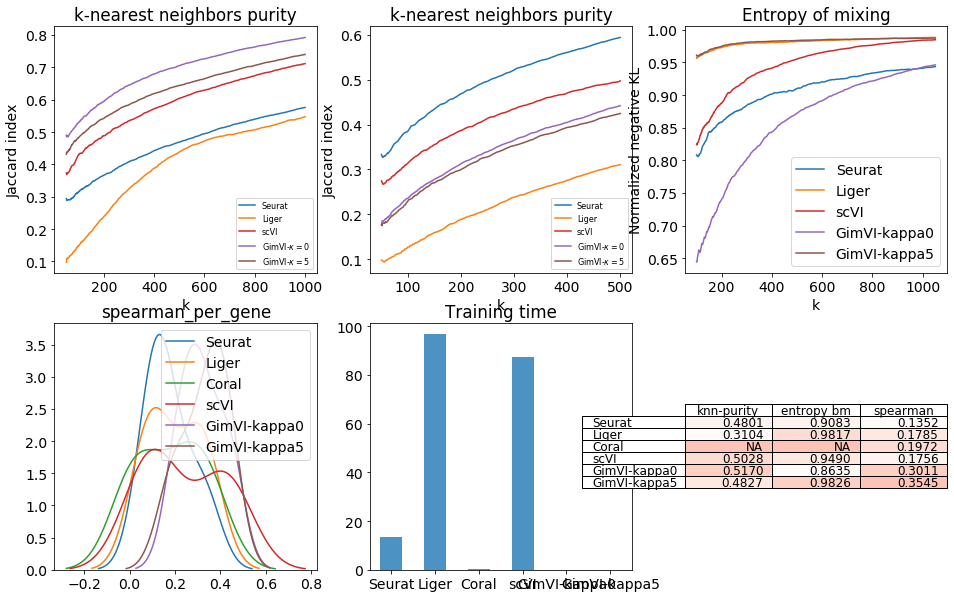

In [22]:
pb = PlotBenchmarkable(
    [
        Benchmarkable.load("Seurat"),
        Benchmarkable.load("Liger"),
        Benchmarkable.load("Coral"),
        Benchmarkable.load("scVI"),
        Benchmarkable.load("GimVI-kappa0"),
        Benchmarkable.load("GimVI-kappa5"),
    ]
)
pb.MAX_KNN = 1000
pb.plot()

In [54]:
import umap
import seaborn as sns
def plot_umap(trainer):
    latent_seq, latent_fish = trainer.get_latent()
    latent2d = umap.UMAP().fit_transform(np.concatenate([latent_seq, latent_fish]))
    latent2d_seq = latent2d[: latent_seq.shape[0]]
    latent2d_fish = latent2d[latent_seq.shape[0] :]

    data_seq, data_fish = [p.gene_dataset for p in trainer.all_dataset]

    colors = sns.color_palette(n_colors=30)
    plt.figure(figsize=(8, 4))
    #ax = plt.subplot(1, 2, 1)
    #ax.axis("off")

    #ax.scatter(*latent2d_seq.T, color="r", label="seq", alpha=0.3, s=1)
    #ax.scatter(*latent2d_fish.T, color="b", label="osm", alpha=0.3, s=1)
    #ax.legend(loc='upper left')

    ax = plt.subplot(1, 2, 1)
    ax.axis("off")
    labels = data_seq.labels.ravel()
    for i, label in enumerate(data_seq.cell_types):
        ax.scatter(
            *latent2d_seq[labels == i].T,
            color=colors[i],
            label=label[:12],
            alpha=0.5,
            s=5
        )
    #ax.legend()
    ax.set_title("Seq cells")

    ax = plt.subplot(1, 2, 2)
    ax.axis("off")

    labels = data_fish.labels.ravel()
    for i, label in enumerate(data_fish.cell_types):
        ax.scatter(
            *latent2d_fish[labels == i].T, color=colors[i], label=label, alpha=0.5, s=5
        )
    #ax.legend()
    ax.set_title("Spatial cells")


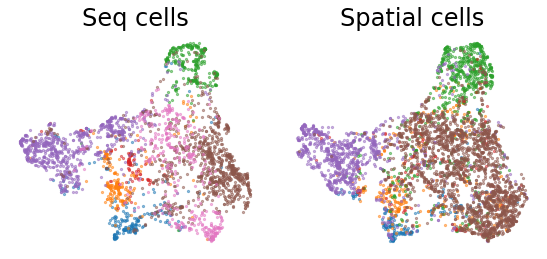

In [55]:
np.random.seed(1)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams['font.size'] =20
plt.rcParams["ps.fonttype"] = 42

plot_umap(Benchmarkable.load("GimVI-kappa5").trainer_both)
plt.tight_layout()
plt.savefig('osmfish-latent.pdf')

## If $\kappa = 0$ we see indeed that the two dataset are not merged

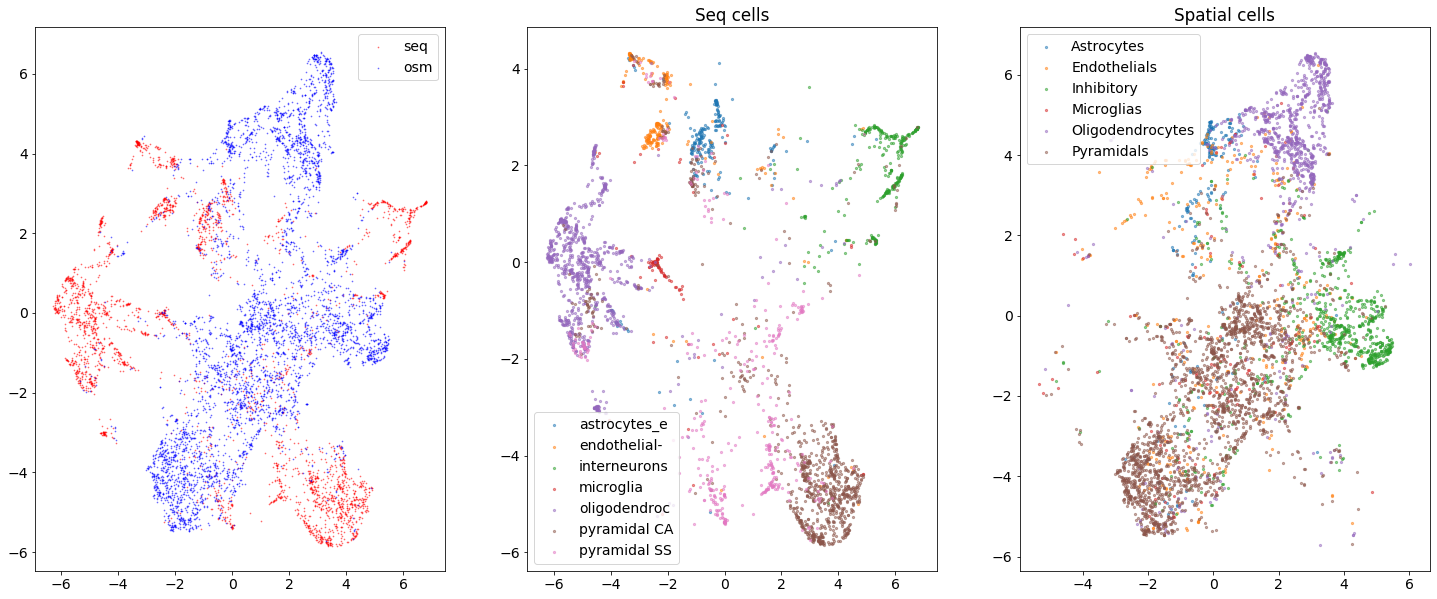

In [43]:
plot_umap(Benchmarkable.load("GimVI-kappa0").trainer_both)

# Uncertainty

In [47]:
import seaborn as sns

In [48]:
samples = np.array([model.trainer_both.get_imputed_values(False)[1][:,model.data.test_indices] for _ in range(50)])

In [49]:
model = Benchmarkable.load("GimVI-kappa5")

In [50]:
from sklearn.linear_model import LinearRegression

samples = np.array(
    [
        model.trainer_both.get_imputed_values(False)[1][:, model.data.test_indices]
        for _ in range(50)
    ]
)
uncertainty = np.std(samples, axis=0).mean(axis=0)


data_seq_normalized = np.log(
    1
    + 10 ** 4
    * model.data.data_seq.X
    / model.data.data_seq.X.sum(axis=1).reshape((-1, 1))
)
X = data_seq_normalized[:, model.data.train_indices]
Y = data_seq_normalized[:, model.data.test_indices]

lr = LinearRegression(normalize=False)
lr.fit(X, Y)

mse = (lr.predict(X) - Y) ** 2
gene_rmse = mse.mean(axis=0) ** 0.5

# Proxy for the correlation measure of test gene to train genes

# Relative error
imputation_me = (
    (model.data.data_fish.X[:, model.data.test_indices] - model.imputed)
    / (model.data.data_fish.X[:, model.data.test_indices] + 1)
).mean(axis=0)

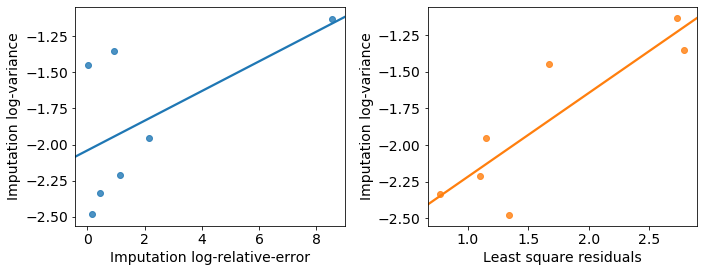

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.regplot(np.abs(imputation_me), np.log10(uncertainty),  ax=axes[0], ci=0)
#axes[0].set_ylim((-8, -5))
axes[0].set_xlabel('Imputation log-relative-error')
axes[0].set_ylabel('Imputation log-variance')


sns.regplot(gene_rmse, np.log10(uncertainty), ci=0, ax=axes[1])
#axes[1].set_ylim((-8, -5))
axes[1].set_xlabel('Least square residuals')
axes[1].set_ylabel('Imputation log-variance')
plt.tight_layout()

In [96]:
def plot_gene_spatial(trainer, data_spatial, gene):
    data_seq, _ = [p.gene_dataset for p in trainer.all_dataset]
    data_fish = data_spatial

    fig, (ax_gt, ax) = plt.subplots(1, 2)

    if type(gene) == str:
        gene_id = list(data_seq.gene_names).index(gene)
    else:
        gene_id = gene

    x_coord = data_fish.x_coord.ravel()
    y_coord = data_fish.y_coord.ravel()

    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]

    s = 20

    def transform(data):
        return np.log(1 + 50 * data)

    # Plot groundtruth
    x, y, z = order_by_strenght(
        x_coord, y_coord, data_fish.X[:, gene_id] / (data_fish.X.sum(axis=1) + 1)
    )
    ax_gt.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax_gt.set_title("Groundtruth")
    ax_gt.axis("off")

    _, imputed = trainer.get_imputed_values(normalized=True)
    x, y, z = order_by_strenght(x_coord, y_coord, imputed[:, gene_id])
    ax.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax.set_title("Imputed")
    ax.axis("off")
    plt.tight_layout()

In [97]:
model = Benchmarkable.load("GimVI-kappa5")

In [98]:
data.test_indices

[0, 3, 7, 9, 19, 27, 31]

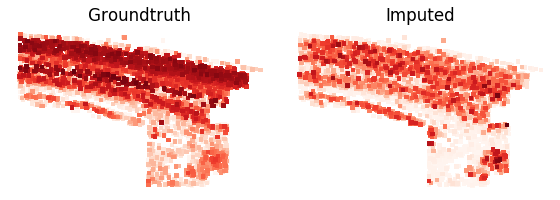

In [99]:
plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams['font.size'] =14
plt.rcParams["ps.fonttype"] = 42
plot_gene_spatial(model.trainer_both, data.data_fish, 9)
plt.savefig('lamp5.pdf')

In [38]:
data.test_indices

[0, 3, 7, 9, 19, 27, 31]